In [1]:
# Imports

from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import keras.backend as K

import numpy as np
import matplotlib.pyplot as plt
import cv2

Using TensorFlow backend.


In [10]:
'''
Load a sample image from local.
Rescale it to dimensions suited for VGG16 
'''

image_path = 'data/Misc/female-elephant.jpg'
input_image = image.load_img(path=image_path, target_size=(224,224)) 

X = image.img_to_array(input_image) # converts the input to the dimensions: (224,224,3)
X = np.expand_dims(X,axis=0) # adds the batch dimension ; i.e. (1,224,224,3)

X_original = X

X = preprocess_input(X) # performs channel-wise colour normalization on the batch of images (X now has batch dimenstion!)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


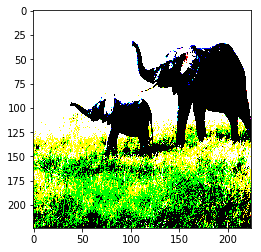

In [11]:
# print(X_original.shape)

plt.imshow(X_original[0])
plt.show()

In [33]:
model = VGG16(weights='imagenet')
FINAL_CONV_LAYER = 'block5_conv3'
FINAL_CONV_OUTPUT_SHAPE = model.get_layer(FINAL_CONV_LAYER).output_shape

print("Final output shape: ", FINAL_CONV_OUTPUT_SHAPE)

Final output shape:  (None, 14, 14, 512)


In [34]:
prediction = model.predict(X)
decoded_predictions = decode_predictions(prediction,top=3)

print("Classes: ", decoded_predictions)

Classes:  [[('n02504458', 'African_elephant', 0.8451774), ('n01871265', 'tusker', 0.14580026), ('n02504013', 'Indian_elephant', 0.008667604)]]


In [35]:
'''
Pick up the index of the most probable class.
Here it's teh index corresponding to the class: African_elephant - which has 84.5% probability
'''
# shows all the prediction scores corresponding to each class ; imagenet has 1000 classes
# print("Prediction: ", prediction[0]) 

print("Class index: ", np.argmax(prediction[0]))

Class index:  386


In [36]:
'''
Use the index info for Gradient CAM (Class Activation Map) based detection.
Use the feature map from the output of the last convolution layer in VGG16 - block5_conv3 (FINAL_CONV_LAYER).

'''

prediction_output = model.output[:,386]
prediction_output = K.print_tensor(prediction_output,message='prediction_output = ') # not working!?

# Here, its a Keras Conv2D layer
final_conv_layer = model.get_layer(FINAL_CONV_LAYER)

# FINAL_CONV_OUTPUT_SHAPE is (None, 14, 14, 512) - only 512 is needed hereafter
FINAL_CONV_OUTPUT_SHAPE = FINAL_CONV_OUTPUT_SHAPE[len(FINAL_CONV_OUTPUT_SHAPE)-1]
# print(FINAL_CONV_OUTPUT_SHAPE)

In [38]:
'''
Gradient CAM approach calculates the gradient for
output feature map of the convolution layer (here, the final_conv_layer)
against the predicted class (here, prediction_output).


Steps:
1. Define which gradients are to be calculated:
    - here, prediction_output and final_conv_layer.output as the inputs
    - this calculates the gradient between the prediction_output and the feature output from the final_conv_layer

2. Calculate the channel_wise_gradients from the above gradient values
3. Feed the above values to the iterate function that expects model input and returns channel_wise_gradients and final_conv_layer.output

Here, the sample input - X is provided to the defined iterate function.
The calculated channel_wise_gradient (intensities) are applied to the final_conv_layer.output through element-wise multiplication

'''

# gradients - Tensor of shape same as FINAL_CONV_LAYER
gradients = K.gradients(prediction_output, final_conv_layer.output)[0]

print(gradients[0])

# Tensor of shape (512.) for each channel - each row corresponds to intensity of a channel
channel_wise_gradients = K.mean(gradients, axis=(0,1,2))
# print(channel_wise_gradients.shape)

iterate = K.function([model.input], [channel_wise_gradients, final_conv_layer.output[0]])

# Applies the above function to the input image array - X
channel_wise_grad_value, final_conv_layer_output_value = iterate([X])

# Applies channel-wise intensities (gradient values) onto the corresponding `final_conv_layer_output_value` elements
for i in range(FINAL_CONV_OUTPUT_SHAPE):
    final_conv_layer_output_value[:,:,i] *= channel_wise_grad_value[i]

# Produces a heatmap of shape (14,14) based on mean values of `final_conv_layer_output_value`
heatmap = np.mean(final_conv_layer_output_value, axis=-1)

# print(heatmap.shape)

Tensor("strided_slice_9:0", shape=(14, 14, 512), dtype=float32)


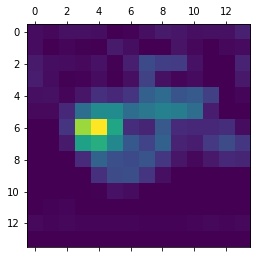

In [39]:
'''
Normalize the heatmap intensities for visualization purposes.

np.maximum() produces element-wise maximum ; either positive or zero
Dividing by np.max() produces normalized values within (0,1) for heatmap.
'''
heatmap = np.maximum(heatmap,0)
heatmap /= np.max(heatmap)

plt.matshow(heatmap)

In [40]:
actual_image = cv2.imread(image_path)

heatmap_resized = cv2.resize(heatmap, (actual_image.shape[1], actual_image.shape[0]))
heatmap_resized = np.uint8(255 * heatmap_resized) # Converts to RGB

heatmap_resized = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
superimposed_image = heatmap_resized * 0.4 + actual_image # 0.4 is the heatmap intensity factor

cv2.imwrite('data/Misc/female-elephant_cam.jpg', superimposed_image)

True

(1, 467, 700, 3)


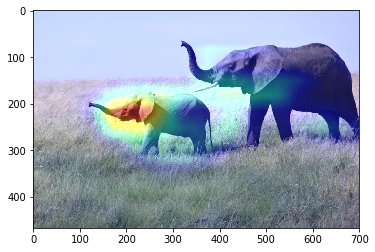

In [41]:
img = image.load_img('data/Misc/female-elephant_cam.jpg',target_size=(superimposed_image.shape[0],superimposed_image.shape[1]))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

print(img_tensor.shape)

plt.imshow(img_tensor[0])
plt.show()